In [113]:
import tensorflow as tf
import tensorflow.data as tfd
import pandas as pd
import numpy as np
import os
import json

In [114]:
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 8
EPOCHS = 15
LEARNING_RATE = 1e-3
MODEL_NAME = "CharacterRecognition-Model"

AUTOTUNE = tfd.AUTOTUNE
CALLBACKS = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_NAME + ".keras", save_best_only=True)
]

# Paths 
img_path = '../Image_preprocessing/Out'
transcriptions = '../dataset/transcriptions.json'

# SetUp random seeds for numpy and TensorFlow
np.random.seed(2569)
tf.random.set_seed(2569)

In [115]:
# Load the json files and transform into dataframes

def json_to_csv(json_path):
    # Load the JSON file
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Convert the data to a pandas DataFrame
    return pd.DataFrame(data)
 
all_transcriptions = json_to_csv(transcriptions)   

In [116]:
all_transcriptions.head()

,decade_id,height,img,nameset,text,width
0,0,130,002_02_00.jpg,train,Lettera di Lod. Antonio,1120
1,0,147,002_02_01.jpg,train,di Giacomo Bianchi,986
2,1,112,002_04_00.jpg,train,Arona 30. 9bre. 94.,657
3,1,82,002_04_01.jpg,train,Sorella amatissima,544
4,1,93,002_04_02.jpg,train,Veramente il vostro caso è degno di compassion...,1654


In [117]:
def filter_no_longer_than_50(df):
    return df[df['text'].apply(lambda x: len(x) <= 50)]

def add_file_path(df):
    df['file_name'] = df['img'].apply(lambda x: img_path + '/' + x)
    return df

def drop_unnecessary_columns(df):
    return df.drop(columns=['decade_id', 'nameset', 'height', 'width'])

def transform_pipeline(df):
    return filter_no_longer_than_50(add_file_path(drop_unnecessary_columns(df)))

all_transcriptions = transform_pipeline(all_transcriptions)

def check_img_exists(df):
    #drop imgs that do not exist
    return df[df['file_name'].apply(lambda x: os.path.exists(x))]

all_transcriptions = check_img_exists(all_transcriptions)

length = len(all_transcriptions)
train_csv = all_transcriptions[:int(length * 0.8)]
test_csv = all_transcriptions[int(length * 0.8):]

length = len(train_csv)
valid_csv = train_csv[int(length * 0.8):]
train_csv = train_csv[:int(length*0.8)]

print(len(train_csv['img']))
print(len(valid_csv['img']))
print(len(test_csv['img']))

TRAIN_SIZE = len(train_csv['img'])
VALID_SIZE = len(valid_csv['img'])
TEST_SIZE = len(test_csv['img'])


15275
3819
4774


In [118]:
train_csv.head()

,img,text,file_name
0,002_02_00.jpg,Lettera di Lod. Antonio,../Image_preprocessing/Out/002_02_00.jpg
1,002_02_01.jpg,di Giacomo Bianchi,../Image_preprocessing/Out/002_02_01.jpg
2,002_04_00.jpg,Arona 30. 9bre. 94.,../Image_preprocessing/Out/002_04_00.jpg
3,002_04_01.jpg,Sorella amatissima,../Image_preprocessing/Out/002_04_01.jpg
5,002_04_03.jpg,"do voi perduta una figlia, che già mostrava",../Image_preprocessing/Out/002_04_03.jpg


In [119]:
# get the train labels 
train_labels = [str(word) for word in train_csv["text"].to_numpy()]
val_labels = [str(word) for word in valid_csv["text"].to_numpy()]
test_labels = [str(word) for word in test_csv["text"].to_numpy()]

# extract all the unique characters
unique_characters_train = set(char for word in train_labels for char in word)
unique_characters_test = set(char for word in test_labels for char in word)
unique_characters_val = set(char for word in val_labels for char in word)

# get the unique characters
unique_characters = unique_characters_train.union(unique_characters_test).union(unique_characters_val)

# define the number of classes (for labels) based on the number of unique characters
n_classes = len(unique_characters)

MAX_LABEL_LENGTH = max(map(len, train_labels))

In [120]:
print("Number of unique characters: ", n_classes)
print("Max label length: ", MAX_LABEL_LENGTH)

Number of unique characters:  88
Max label length:  50


In [121]:
from keras.src.layers import StringLookup

# Char to Num
char_to_num = StringLookup(vocabulary=list(unique_characters), mask_token=None)
num_to_char = StringLookup(vocabulary = char_to_num.get_vocabulary(), mask_token = None, invert = True)

In [122]:
unk = char_to_num('[UNK]')

In [123]:
def load_image(image_path):
    """
    This function gets the image path and 
    reads the image using TensorFlow, Then the image will be decoded and 
    will be converted to float data type. next resize and transpose will be applied to it.
    In the final step the image will be converted to a Numpy Array using tf.cast
    """
    # read the image
    image = tf.io.read_file(image_path)
    # decode the image
    decoded_image = tf.image.decode_jpeg(contents=image, channels=1)
    # convert image data type to float32
    convert_imgs = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
    # resize and transpose 
    resized_image = tf.image.resize(images=convert_imgs, size=(IMG_HEIGHT, IMG_WIDTH))
    image = tf.transpose(resized_image, perm = [1, 0, 2])

    # to numpy array (Tensor)
    image_array = tf.cast(image, dtype=tf.float32)

    return image_array

In [124]:
def encode_single_sample(image_path, label:str):
    if image_path is None:
        print("Found None in image_path")
        raise ValueError("Image path is None")
    if label is None:
        print("Found None in label")
        raise ValueError("Label is None")
    
    # Get the image
    image = load_image(image_path)
    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    # Convert the characters into vectors
    vecs = char_to_num(chars)
    
    # Create a list to hold the valid vectors
    oov_found = tf.constant(0)
    for vec in vecs:
        if vec == char_to_num('[UNK]'):
            print(f"Found OOV token in vec: {vec}")
            oov_found = tf.constant(1)
            break
            

    # Pad label
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)

    return {'image':image, 'label':vecs, 'oov_found':oov_found}

In [125]:
train_images = train_csv['file_name'].to_numpy()
test_images = test_csv['file_name'].to_numpy()
valid_images = valid_csv['file_name'].to_numpy()

In [126]:
def lay_dataset(images, labels, shuffle = True):
    if shuffle:
        ds = tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((images, labels)).map(encode_single_sample, num_parallel_calls=AUTOTUNE)
    
    # Filter out the samples with OOV tokens
    ds = ds.filter(lambda sample: tf.equal(sample['oov_found'], 0))
    
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [127]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

In [128]:
train_ds = lay_dataset(train_images, train_labels)
valid_ds = lay_dataset(valid_images, val_labels, shuffle=False)
test_ds = lay_dataset(test_images, test_labels, shuffle=False)

Found OOV token in vec: Tensor("while/TensorArrayV2Read/TensorListGetItem:0", shape=(), dtype=int64)
Found OOV token in vec: Tensor("while/TensorArrayV2Read/TensorListGetItem:0", shape=(), dtype=int64)
Found OOV token in vec: Tensor("while/TensorArrayV2Read/TensorListGetItem:0", shape=(), dtype=int64)


In [129]:
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls


def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):
    
    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID
    
    # Loading Data 
    data = next(iter(data))
    images, labels = data['image'], data['label']
    
    # Iterate over the data 
    for index, (image, label) in enumerate(zip(images, labels)):
        
        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()
        
        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')
        
        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()

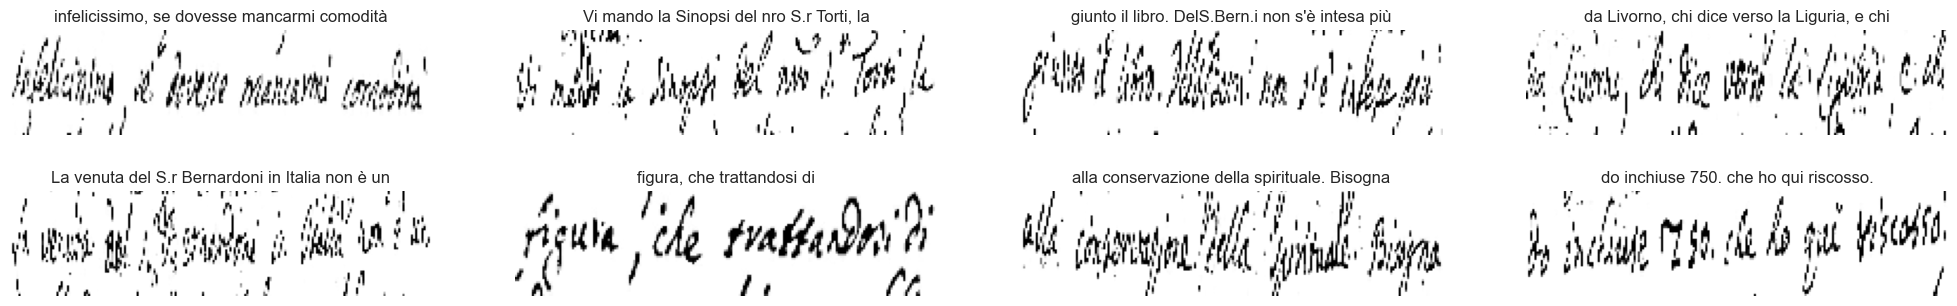

In [130]:
show_images(data=train_ds, GRID=[4,4], FIGSIZE=(25, 8))

In [131]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model 

In [132]:
class CTCLayer(Layer):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        # define the loss function 
        self.loss_function = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_hat):
        # Get the batch length 
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

        # get the input and label lengths
        input_len = tf.cast(tf.shape(y_hat)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')

        # calculate the loss
        loss = self.loss_function(y_true, y_hat, input_len, label_len) 

        self.add_loss(loss)

        return y_hat

In [133]:
# Input Layer
input_images = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
input_labels = Input(shape=(None, ), name="label")

### Convolutional layers
# layer 1 
conv_1 = Conv2D(64, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_1")(input_images)
# layer 2
conv_2 = Conv2D(32, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_2")(conv_1)
max_pool_1 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_2)
# layer 3
conv_3 = Conv2D(64, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_3")(max_pool_1)
conv_4 = Conv2D(32, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_4")(conv_3)
max_pool_2 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_4)



### Encoding 
reshape = Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*32), name="reshape_layer")(max_pool_2)
dense_encoding = Dense(64, kernel_initializer="he_normal", activation="relu", name="enconding_dense")(reshape)
dense_encoding_2 = Dense(64, kernel_initializer="he_normal", activation="relu", name="enconding_dense_2")(dense_encoding)
dropout = Dropout(0.4)(dense_encoding_2)

# Decoder
lstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25), name="bidirectional_lstm_1")(dropout)
lstm_2 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25), name="bidirectional_lstm_2")(lstm_1)

# Final Output layer
output = Dense(len(char_to_num.get_vocabulary())+1, activation="softmax", name="output_dense")(lstm_2)

# Add the CTC loss 
ctc_loss_layer = CTCLayer()(input_labels, output) 

# Define the final model
model = Model(inputs=[input_images, input_labels], outputs=[ctc_loss_layer])

In [134]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 200, 50,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 200, 50,   │     18,464 │ conv_1[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 100, 25,   │          0 │ conv_2[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, 100, 25,   │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4 (Conv2D)     │ (None, 100, 25,   │     18,464 │ conv_3[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 50, 12,    │          0 │ conv_4[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_layer       │ (None, 50, 384)   │          0 │ max_pooling2d_7[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enconding_dense     │ (None, 50, 64)    │     24,640 │ reshape_layer[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enconding_dense_2   │ (None, 50, 64)    │      4,160 │ enconding_dense[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 50, 64)    │          0 │ enconding_dense_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm… │ (None, 50, 256)   │    197,632 │ dropout_3[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm… │ (None, 50, 128)   │    164,352 │ bidirectional_ls… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 50, 90)    │     11,610 │ bidirectional_ls… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_layer_3         │ (None, 50, 90)    │          0 │ label[0][0],      │
│ (CTCLayer)          │                   │            │ output_dense[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 458,458 (1.75 MB)

 Trainable params: 458,458 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [135]:
model.compile(optimizer="adam")

In [136]:
def check_none_values(dataset):
    for batch in dataset:
        for data in batch:
            if data is None:
                return True
    return False

# Check train_ds
if check_none_values(train_ds):
    print("None values found in train_ds")

# Check valid_ds
if check_none_values(valid_ds):
    print("None values found in valid_ds")

# If no None values are found, proceed with fitting the model
if not check_none_values(train_ds) and not check_none_values(valid_ds):
    history = model.fit(train_ds.repeat(), validation_data=valid_ds.repeat(), epochs=EPOCHS, callbacks=CALLBACKS, steps_per_epoch = int(TRAIN_SIZE/BATCH_SIZE), validation_steps = VALID_SIZE//BATCH_SIZE)
else:
    print("Datasets contain None values. Please fix the data before training the model.")

Epoch 1/15
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 580s 302ms/step - loss: inf - val_loss: inf
Epoch 2/15
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 335s 176ms/step - loss: inf - val_loss: inf
Epoch 3/15
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 232s 122ms/step - loss: inf - val_loss: inf
Epoch 4/15
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 233s 122ms/step - loss: inf - val_loss: inf
Epoch 5/15
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 321s 168ms/step - loss: inf - val_loss: inf
Epoch 6/15
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 233s 122ms/step - loss: inf - val_loss: inf
Epoch 7/15
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 233s 122ms/step - loss: inf - val_loss: inf
Epoch 8/15
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 232s 121ms/step - loss: inf - val_loss: inf
Epoch 9/15
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 232s 122ms/step - loss: inf - val_loss: inf
Epoch 10/15
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 233s 122ms/step - loss: inf - val_loss: inf


In [141]:
# evaluate the model on the test dataset 
evaluation = model.evaluate(test_ds.repeat())
print(f"evaluation loss: {evaluation}")

  17060/Unknown 731s 43ms/step - loss: inf

KeyboardInterrupt: 

In [142]:
def decoder_prediction(pred_label):
    """
    This function has the job to decode the prediction that the model had.
    The model predicts each character and then this function makes it readable. 
    """
    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]
    
    # CTC decode
    decode = tf.keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]
    
    # Converting numerics back to their character values
    chars = num_to_char(decode)
    
    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]
    
    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]
    
    return filtered_texts

In [143]:
prediction_model = Model(input_images, output)

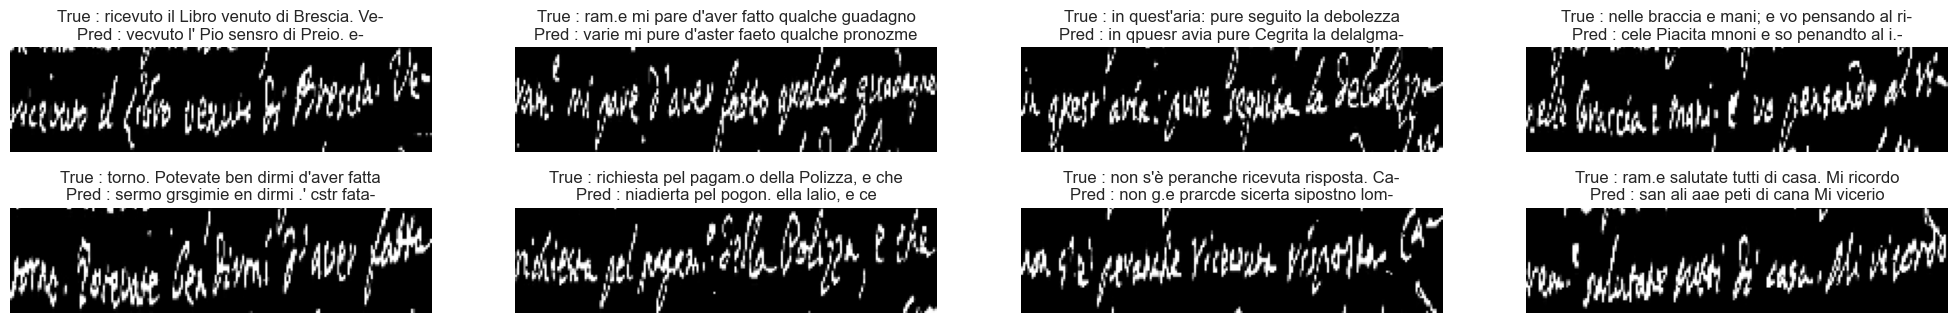

In [144]:
show_images(data=test_ds, model=prediction_model, decode_pred=decoder_prediction, cmap='binary')